<a href="https://colab.research.google.com/github/o-semenkova/ml_home_tasks/blob/main/HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [462]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    roc_auc_score, f1_score
)
import joblib

In [423]:
drive.mount('/content/drive')
base_df = pd.read_csv("/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train.csv")
base_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [424]:
base_df.isna().sum()

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [425]:
base_df.drop(['id','CustomerId', 'Surname'], axis=1, inplace=True)

In [426]:
train_val_df, test_df = train_test_split(base_df, test_size=0.2, random_state=42, stratify=base_df['Exited'])
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['Exited'])

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору. - **Зроблено нижче у ноутбуці, бо структура трохи змінилась**

In [427]:
target_col = 'Exited'

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно. **Зроблено нижче у ноутбуці, бо структура трохи змінилась**

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [428]:
train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
63,743.0,France,Male,36.0,5.0,0.00,2.0,0.0,1.0,89893.60,0.0
13717,607.0,France,Male,35.0,6.0,0.00,2.0,1.0,1.0,152733.89,0.0
13292,775.0,France,Female,33.0,6.0,121355.99,1.0,1.0,0.0,141152.28,0.0
9615,586.0,Spain,Male,48.0,1.0,0.00,1.0,0.0,1.0,149946.43,1.0
1618,710.0,France,Male,32.0,5.0,0.00,2.0,1.0,0.0,68400.14,0.0


In [429]:
train_df.select_dtypes(include=np.number).describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.0
mean,658.58,37.68,5.02,43029.89,1.59,0.79,0.49,117966.92,0.2
std,72.00,8.12,2.78,59826.88,0.53,0.41,0.50,45719.05,0.4
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83092.52,0.0
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123542.16,0.0
75%,708.00,42.00,7.00,109735.03,2.00,1.00,1.00,157097.09,0.0
max,850.00,72.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.0


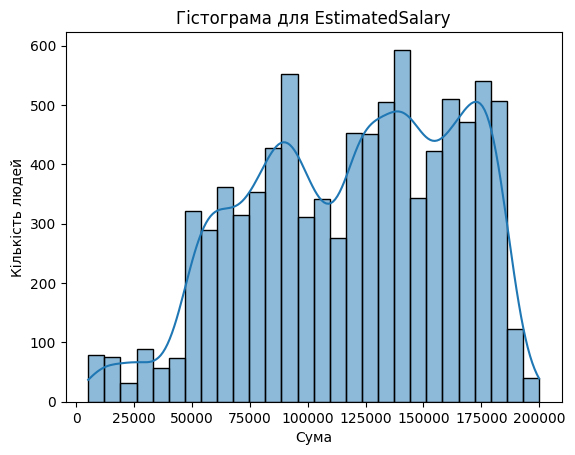

In [430]:
train_df_salary_filtered = train_df[train_df['EstimatedSalary'] > 5000]
sns.histplot(data=train_df_salary_filtered, x='EstimatedSalary', kde=True)
plt.title('Гістограма для EstimatedSalary')
plt.xlabel('Сума')
plt.ylabel('Кількість людей')
plt.show()

In [431]:
Q1 = train_df['EstimatedSalary'].quantile(0.25)
Q3 = train_df['EstimatedSalary'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [432]:
lower_bound, upper_bound

(np.float64(-27914.32250000001), np.float64(268103.9375))

In [433]:
corr = train_df.corr(numeric_only=True)
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.013107,0.000192,-0.006273,0.018414,-0.006357,0.001508,-0.002707,-0.047654
Age,-0.013107,1.000000,-0.015741,0.076464,-0.149140,-0.004475,-0.036103,-0.014708,0.478803
Tenure,0.000192,-0.015741,1.000000,-0.014175,0.000772,0.028844,-0.018890,0.002022,-0.009380
Balance,-0.006273,0.076464,-0.014175,1.000000,-0.436210,-0.005553,-0.005358,-0.005931,0.149967
NumOfProducts,0.018414,-0.149140,0.000772,-0.436210,1.000000,0.000354,0.020583,-0.005954,-0.278159
HasCrCard,-0.006357,-0.004475,0.028844,-0.005553,0.000354,1.000000,-0.022632,-0.005836,-0.015804
IsActiveMember,0.001508,-0.036103,-0.018890,-0.005358,0.020583,-0.022632,1.000000,-0.017389,-0.190262
EstimatedSalary,-0.002707,-0.014708,0.002022,-0.005931,-0.005954,-0.005836,-0.017389,1.000000,0.021675
Exited,-0.047654,0.478803,-0.009380,0.149967,-0.278159,-0.015804,-0.190262,0.021675,1.000000


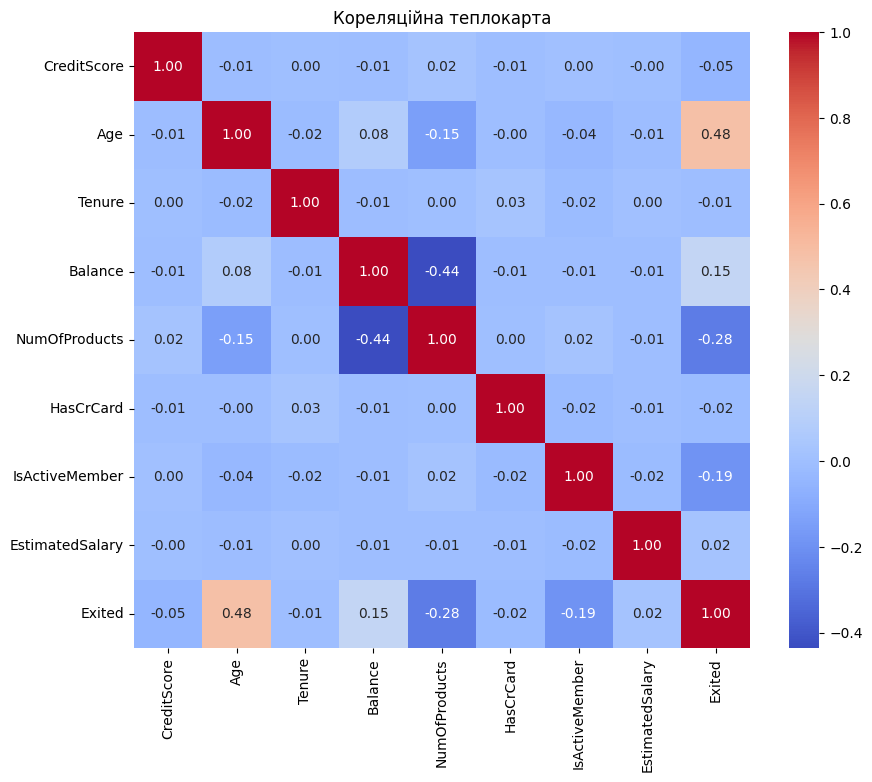

In [434]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Кореляційна теплокарта")
plt.show()

In [435]:
significant_num_features = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance']

In [436]:
categorical_cols = train_df.select_dtypes('object').columns.tolist()
train_df[categorical_cols].nunique()

,0
Geography,3
Gender,2


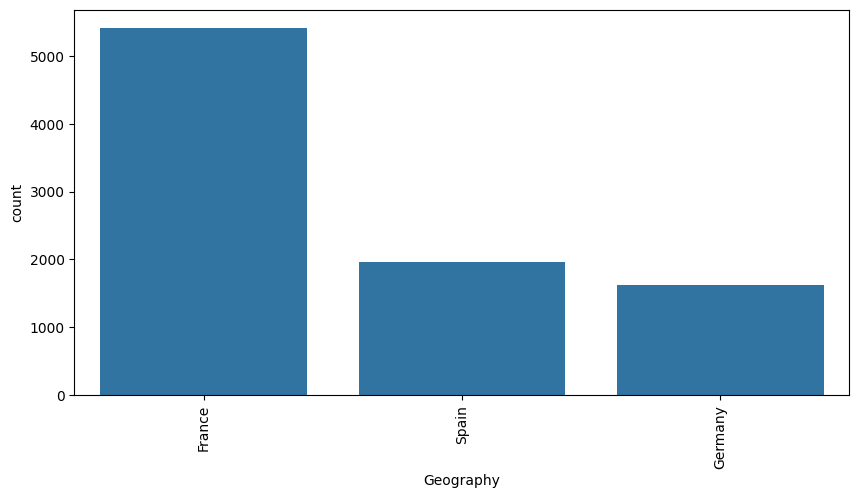

In [437]:
plt.figure(figsize = (10,5))
sns.countplot(data = train_df, x = "Geography")
plt.xticks(rotation = 90)
plt.show()

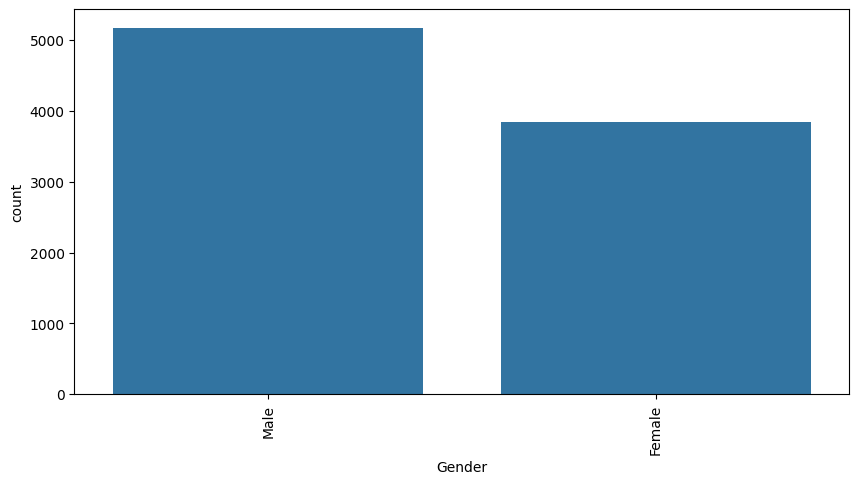

In [438]:
plt.figure(figsize = (10,5))
sns.countplot(data = train_df, x = "Gender")
plt.xticks(rotation = 90)
plt.show()

In [439]:
# 1. Відтік у розрізі HasCrCard (чи є кредитна картка)
print("HasCrCard:")
print(train_df.groupby('HasCrCard')['Exited'].mean(), "\n")

# 2. Відтік у розрізі IsActiveMember (чи активний клієнт)
print("IsActiveMember:")
print(train_df.groupby('IsActiveMember')['Exited'].mean(), "\n")

# 3. Відтік у розрізі NumOfProducts (кількість банківських продуктів)
print("NumOfProducts:")
print(train_df.groupby('NumOfProducts')['Exited'].mean())

HasCrCard:
HasCrCard
0.0    0.215801
1.0    0.200169
Name: Exited, dtype: float64 

IsActiveMember:
IsActiveMember
0.0    0.278553
1.0    0.125340
Name: Exited, dtype: float64 

NumOfProducts:
NumOfProducts
1.0    0.376583
2.0    0.044641
3.0    0.957746
4.0    1.000000
Name: Exited, dtype: float64


In [440]:
train_df['NumOfProducts'].value_counts()


,count
NumOfProducts,
2.0,4973
1.0,3869
3.0,142
4.0,16


In [441]:
def simplify_products(x):
    if x == 1:
        return '1'
    elif x == 2:
        return '2'
    else:
        return '3'

train_df['ProductGroup'] = train_df['NumOfProducts'].apply(simplify_products)
train_df.groupby('ProductGroup')['Exited'].mean()

,Exited
ProductGroup,
1,0.376583
2,0.044641
3,0.962025


In [442]:
print("Geography:")
print(train_df.groupby('Geography')['Exited'].mean())

print("Gender:")
print(train_df.groupby('Gender')['Exited'].mean())

Geography:
Geography
France     0.161404
Germany    0.415640
Spain      0.143804
Name: Exited, dtype: float64
Gender:
Gender
Female    0.283516
Male      0.144019
Name: Exited, dtype: float64


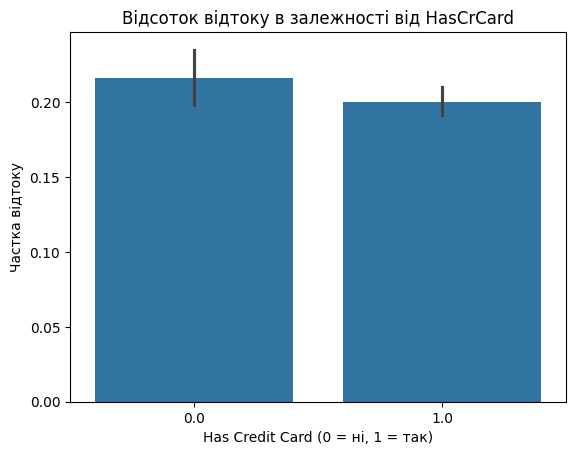

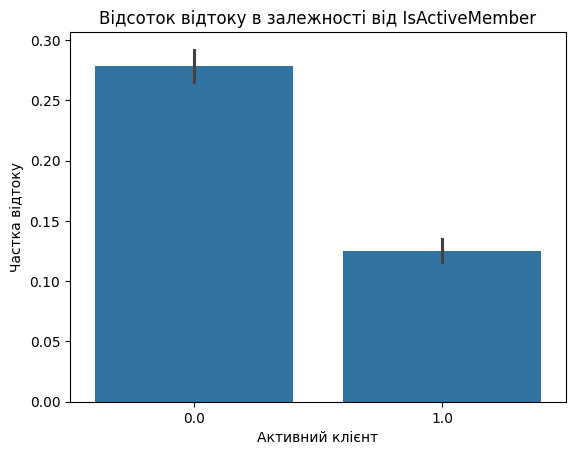

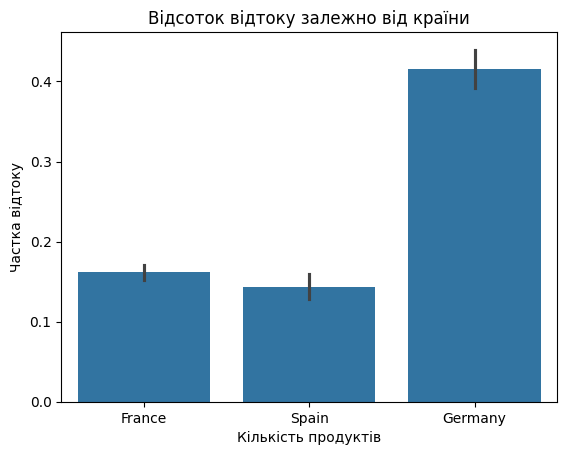

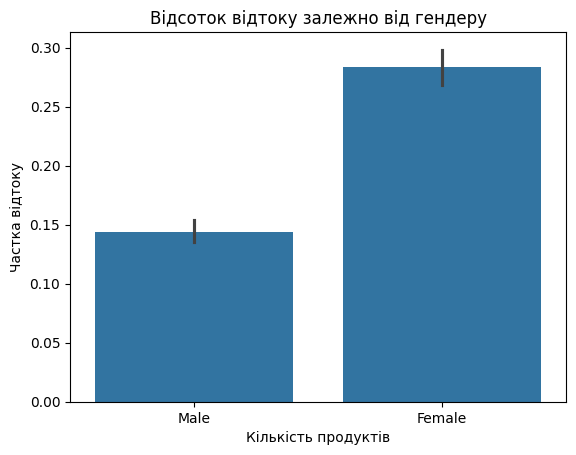

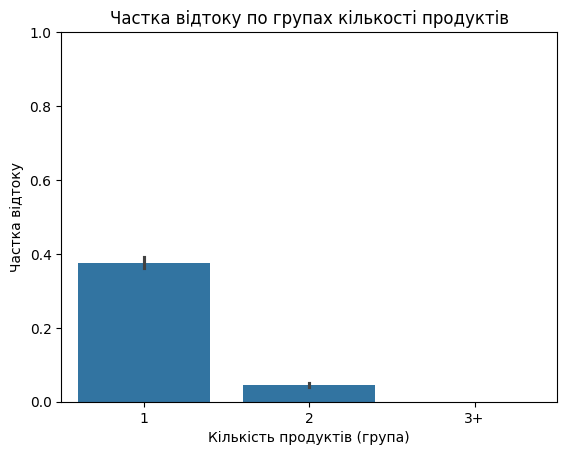

In [443]:
# HasCrCard
sns.barplot(data=train_df, x='HasCrCard', y='Exited')
plt.title('Відсоток відтоку в залежності від HasCrCard')
plt.ylabel('Частка відтоку')
plt.xlabel('Has Credit Card (0 = ні, 1 = так)')
plt.show()

# IsActiveMember
sns.barplot(data=train_df, x='IsActiveMember', y='Exited')
plt.title('Відсоток відтоку в залежності від IsActiveMember')
plt.ylabel('Частка відтоку')
plt.xlabel('Активний клієнт')
plt.show()

# Geography
sns.barplot(data=train_df, x='Geography', y='Exited')
plt.title('Відсоток відтоку залежно від країни')
plt.ylabel('Частка відтоку')
plt.xlabel('Кількість продуктів')
plt.show()

# Gender
sns.barplot(data=train_df, x='Gender', y='Exited')
plt.title('Відсоток відтоку залежно від гендеру')
plt.ylabel('Частка відтоку')
plt.xlabel('Кількість продуктів')
plt.show()

sns.barplot(x=train_df['ProductGroup'], y=train_df['Exited'], order=['1', '2', '3+'])
plt.title('Частка відтоку по групах кількості продуктів')
plt.xlabel('Кількість продуктів (група)')
plt.ylabel('Частка відтоку')
plt.ylim(0, 1)
plt.show()

In [444]:
significant_cat_features = ['IsActiveMember', 'Geography', 'Gender', 'ProductGroup']
significant_features = significant_num_features + significant_cat_features

In [445]:
train_inputs = train_df[significant_features].copy()
train_targets = train_df[target_col].copy()

val_df['ProductGroup'] = val_df['NumOfProducts'].apply(simplify_products)
val_inputs = val_df[significant_features].copy()
val_targets = val_df[target_col].copy()

In [446]:
train_inputs.head()

,Age,NumOfProducts,IsActiveMember,Balance,IsActiveMember,Geography,Gender,ProductGroup
63,36.0,2.0,1.0,0.00,1.0,France,Male,2
13717,35.0,2.0,1.0,0.00,1.0,France,Male,2
13292,33.0,1.0,0.0,121355.99,0.0,France,Female,1
9615,48.0,1.0,1.0,0.00,1.0,Spain,Male,1
1618,32.0,2.0,0.0,0.00,0.0,France,Male,2


In [447]:
val_inputs.head()

,Age,NumOfProducts,IsActiveMember,Balance,IsActiveMember,Geography,Gender,ProductGroup
4434,40.0,1.0,1.0,133628.09,1.0,France,Male,1
8707,34.0,2.0,1.0,0.00,1.0,France,Male,2
679,34.0,2.0,0.0,0.00,0.0,France,Male,2
4765,39.0,2.0,1.0,0.00,1.0,France,Male,2
9354,39.0,2.0,1.0,99713.87,1.0,Germany,Female,2


In [448]:
scaler = MinMaxScaler()
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [449]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [450]:
val_inputs.head()

,Age,NumOfProducts,IsActiveMember,Balance,IsActiveMember,Geography,Gender,ProductGroup
4434,0.407407,0.000000,1.0,0.637030,1.0,France,Male,1
8707,0.296296,0.333333,1.0,0.000000,1.0,France,Male,2
679,0.296296,0.333333,0.0,0.000000,0.0,France,Male,2
4765,0.388889,0.333333,1.0,0.000000,1.0,France,Male,2
9354,0.388889,0.333333,1.0,0.475355,1.0,Germany,Female,2


In [451]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(train_inputs[significant_cat_features])
encoded_cols = list(encoder.get_feature_names_out())

In [452]:
encoded_array = encoder.transform(train_inputs[significant_cat_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=train_inputs.index)

# З'єднання з оригінальним датафреймом:
train_inputs = pd.concat([train_inputs.drop(columns=significant_cat_features), encoded_df], axis=1)

In [453]:
encoded_array = encoder.transform(val_inputs[significant_cat_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=val_inputs.index)

# З'єднання з оригінальним датафреймом:
val_inputs = pd.concat([val_inputs.drop(columns=significant_cat_features), encoded_df], axis=1)

In [454]:
train_inputs.head()

,Age,NumOfProducts,Balance,IsActiveMember_1.0,IsActiveMember_1.0,Geography_Germany,Geography_Spain,Gender_Male,ProductGroup_2,ProductGroup_3
63,0.333333,0.333333,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0
13717,0.314815,0.333333,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0
13292,0.277778,0.000000,0.578527,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9615,0.555556,0.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1618,0.259259,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [455]:
val_inputs.head()

,Age,NumOfProducts,Balance,IsActiveMember_1.0,IsActiveMember_1.0,Geography_Germany,Geography_Spain,Gender_Male,ProductGroup_2,ProductGroup_3
4434,0.407407,0.000000,0.637030,1.0,1.0,0.0,0.0,1.0,0.0,0.0
8707,0.296296,0.333333,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0
679,0.296296,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4765,0.388889,0.333333,0.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0
9354,0.388889,0.333333,0.475355,1.0,1.0,1.0,0.0,0.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [342]:
!pip install pyarrow --quiet

In [456]:
train_inputs = train_inputs.loc[:, ~train_inputs.columns.duplicated()]
val_inputs = val_inputs.loc[:, ~val_inputs.columns.duplicated()]


In [457]:
train_inputs.to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train_inputs.parquet')
val_inputs.to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/val_inputs.parquet')
train_targets.to_frame().to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train_targets.parquet')
val_targets.to_frame().to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/val_targets.parquet')

In [458]:
os.listdir('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification')

['train.csv',
 'train_inputs.parquet',
 'val_inputs.parquet',
 'train_targets.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [459]:
model = LogisticRegression(solver='liblinear')
model.fit(train_inputs, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [463]:
def evaluate_model(model, X, y, dataset_name='Dataset'):
    # 1. Прогноз ймовірностей
    y_proba = model.predict_proba(X)[:, 1]

    # 2. Прогноз класів при порозі 0.5
    y_pred = (y_proba >= 0.5).astype(int)

    # 3. Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.show()

    # 4. ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f'ROC Curve: {dataset_name}')
    plt.show()

    # 5. Метрики
    auc = roc_auc_score(y, y_proba)
    f1 = f1_score(y, y_pred)

    print(f"📊 {dataset_name} — AUROC: {auc:.3f}, F1 Score (threshold=0.5): {f1:.3f}")


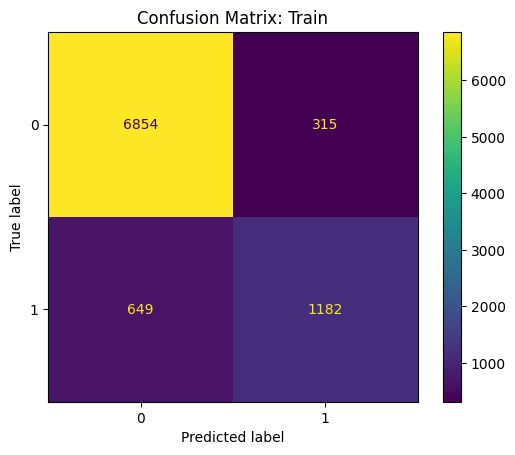

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


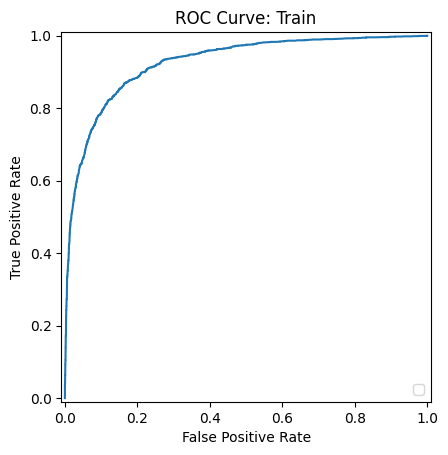

📊 Train — AUROC: 0.925, F1 Score (threshold=0.5): 0.710


In [465]:
evaluate_model(model, train_inputs, train_targets, 'Train')

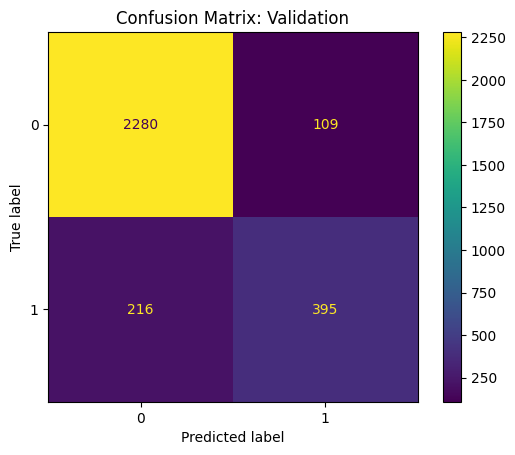

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


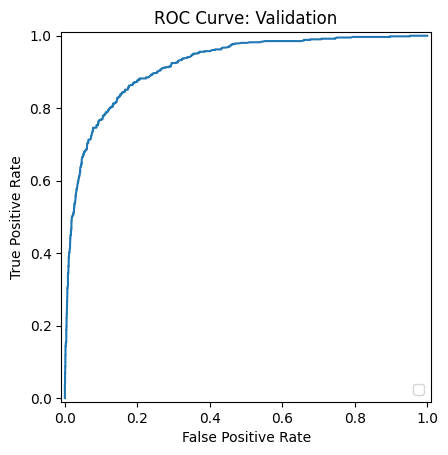

📊 Validation — AUROC: 0.921, F1 Score (threshold=0.5): 0.709


In [466]:
evaluate_model(model, val_inputs, val_targets, 'Validation')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [469]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

def compare_with_baseline_detailed(model, train_inputs, train_targets, val_inputs, val_targets):
    # 1. Мажоритарний клас
    majority_class = train_targets.mode()[0]

    # 2. Мажоритарні передбачення
    train_baseline_preds = [majority_class] * len(train_targets)
    val_baseline_preds = [majority_class] * len(val_targets)

    # 3. Модельні передбачення
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)

    # 4. Функція підрахунку метрик
    def compute_metrics(y_true, y_pred):
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred),
            "F1 Score": f1_score(y_true, y_pred)
        }

    # 5. Обчислення метрик
    results = {
        "Train (Model)": compute_metrics(train_targets, train_preds),
        "Train (Baseline)": compute_metrics(train_targets, train_baseline_preds),
        "Validation (Model)": compute_metrics(val_targets, val_preds),
        "Validation (Baseline)": compute_metrics(val_targets, val_baseline_preds),
    }

    # 6. Вивід
    for name, metrics in results.items():
        print(f"\n📊 {name}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")



def compare_metrics_barplot(model, train_inputs, train_targets, val_inputs, val_targets):
    majority_class = train_targets.mode()[0]

    # Модельні передбачення
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)

    # Базові передбачення
    train_baseline = [majority_class] * len(train_targets)
    val_baseline = [majority_class] * len(val_targets)

    # Обчислення всіх метрик
    def collect_metrics(y_true, y_pred, label):
        return pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            'Value': [
                accuracy_score(y_true, y_pred),
                precision_score(y_true, y_pred, zero_division=0),
                recall_score(y_true, y_pred),
                f1_score(y_true, y_pred)
            ],
            'Set': label
        })

    df_metrics = pd.concat([
        collect_metrics(train_targets, train_preds, 'Train - Model'),
        collect_metrics(train_targets, train_baseline, 'Train - Baseline'),
        collect_metrics(val_targets, val_preds, 'Val - Model'),
        collect_metrics(val_targets, val_baseline, 'Val - Baseline'),
    ])

    # Побудова графіка
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metrics, x='Metric', y='Value', hue='Set')
    plt.title('📊 Модель vs Мажоритарна модель (усі метрики)')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()


def plot_roc_curves_comparison(model, train_inputs, train_targets, val_inputs, val_targets):
    # Ймовірності позитивного класу
    train_probs = model.predict_proba(train_inputs)[:, 1]
    val_probs = model.predict_proba(val_inputs)[:, 1]

    # Мажоритарна модель — постійне значення (наприклад, 0)
    majority_class = train_targets.mode()[0]
    baseline_train_probs = np.full(len(train_targets), majority_class)
    baseline_val_probs = np.full(len(val_targets), majority_class)

    # Розрахунок ROC кривих
    fpr_train, tpr_train, _ = roc_curve(train_targets, train_probs)
    fpr_val, tpr_val, _ = roc_curve(val_targets, val_probs)
    fpr_baseline_train, tpr_baseline_train, _ = roc_curve(train_targets, baseline_train_probs)
    fpr_baseline_val, tpr_baseline_val, _ = roc_curve(val_targets, baseline_val_probs)

    # Побудова графіка
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train - Model (AUC = {roc_auc_score(train_targets, train_probs):.3f})")
    plt.plot(fpr_val, tpr_val, label=f"Val - Model (AUC = {roc_auc_score(val_targets, val_probs):.3f})")
    plt.plot(fpr_baseline_train, tpr_baseline_train, linestyle='--', label="Train - Baseline")
    plt.plot(fpr_baseline_val, tpr_baseline_val, linestyle='--', label="Val - Baseline")
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label="Random (AUC = 0.5)")

    plt.title('📈 ROC-криві: Модель vs Базова модель')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [470]:
compare_with_baseline_detailed(model, train_inputs, train_targets, val_inputs, val_targets)


📊 Train (Model)
Accuracy: 0.893
Precision: 0.790
Recall: 0.646
F1 Score: 0.710

📊 Train (Baseline)
Accuracy: 0.797
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

📊 Validation (Model)
Accuracy: 0.892
Precision: 0.784
Recall: 0.646
F1 Score: 0.709

📊 Validation (Baseline)
Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


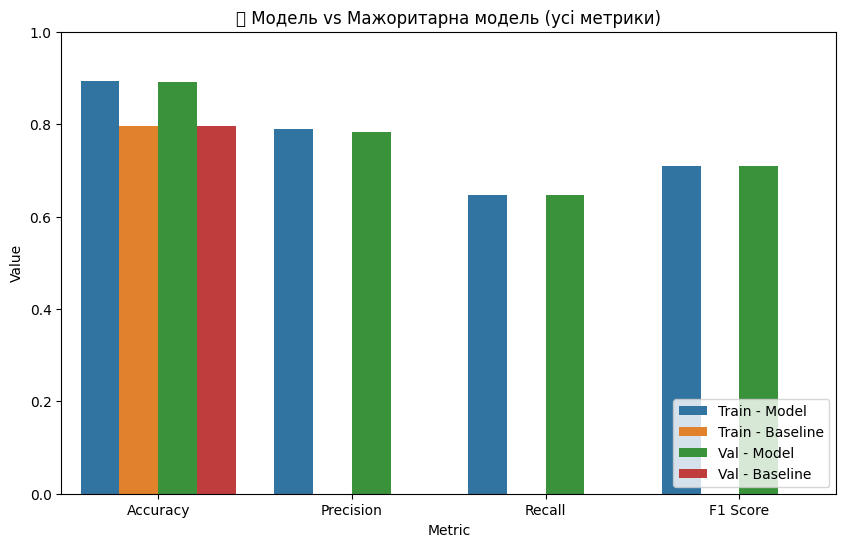

In [471]:
compare_metrics_barplot(model, train_inputs, train_targets, val_inputs, val_targets)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


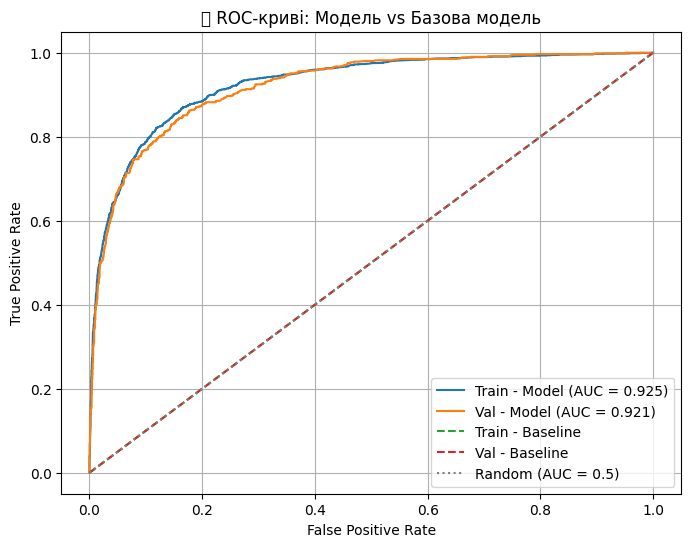

In [472]:
plot_roc_curves_comparison(model, train_inputs, train_targets, val_inputs, val_targets)


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [8]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [9]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

NameError: name 'scaler' is not defined

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.